In [1]:
import pandas as pd
import numpy as np
import torch as pt
import tqdm
from scipy.linalg import qr
import matplotlib.pyplot as plt
%matplotlib inline

#pt.set_default_tensor_type('torch.FloatTensor')
pt.set_default_tensor_type('torch.cuda.FloatTensor')

In [2]:
from ml_lib.Controller import Controller as Control
#from ml_lib.clusters.root_cluster.RootCluster import RootCluster as Root
from ml_lib.clusters.data_cluster.DataCluster import DataCluster as Data
from ml_lib.clusters.learn_cluster.LearnCluster import LearnCluster as Learn
from ml_lib.clusters.merge_cluster.MergeCluster import MergeCluster as Merge

In [3]:
from ml_lib.clusters.learn_cluster.modules.learners.GradientLearner import GradientLearner
from ml_lib.clusters.learn_cluster.modules.learners.NewtonLearner import NewtonLearner
from ml_lib.clusters.learn_cluster.modules.learners.MomentumLearner import MomentumLearner
from ml_lib.clusters.learn_cluster.modules.learners.SmoothLearner import SmoothLearner

from ml_lib.clusters.learn_cluster.modules.activators.LinearActivate import LinearActivate
from ml_lib.clusters.learn_cluster.modules.activators.SigmoidActivate import SigmoidActivate
from ml_lib.clusters.learn_cluster.modules.activators.TanhActivator import TanhActivator
from ml_lib.clusters.learn_cluster.modules.activators.ReluActivator import ReluActivator

from ml_lib.clusters.data_cluster.losses.CrossEntLoss import CrossEntLoss
from ml_lib.utils.regularizers.RidgeRegularizer import RidgeRegularizer
from ml_lib.utils.regularizers.LassoRegularizer import LassoRegularizer
from ml_lib.utils.regularizers.DualRegularizer import DualRegularizer

In [4]:
dataset = pd.read_csv(
    'data_files/kc_house_data.csv',
    index_col = 'id', parse_dates = ['date'], date_parser = lambda x: pd.datetime.strptime(x, '%Y%m%dT%H%M%S')
)
dataset = dataset[[col for col in dataset.columns if not col.endswith('15')]]
feature_cols = ['sqft_living', 'bedrooms', 'bathrooms']
target_cols = ['price']
dataset[target_cols] = np.log(dataset[target_cols])

In [5]:
verbose = False

learner = SmoothLearner
learner_kwargs = {
    'learn_rate': 1e-1
}

loss_kwargs = {}

nesterov = True

activator = ReluActivator
activator_kwargs = {
    'leak': 0.1
}

batcher_kwargs = {
    'proportion': 1.0
}

control = Control(
    'regression_controller',
    regularizer = DualRegularizer, regularizer_kwargs = {'l1': 0, 'l2': 0}
)

control.add_cluster(
    Data(
        'data_cluster',
        dataset[feature_cols + target_cols],
        splitter_kwargs = {'verbose': verbose},
        batcher_kwargs = {'verbose': verbose, **batcher_kwargs},
        loss_kwargs = {'verbose': verbose, **loss_kwargs},
        loss_combiner_kwargs = {'verbose': verbose},
        verbose = verbose
    )
)

control.link_add(
    Learn(
        'learn_cluster_1',
        module_kwargs = {
            'nodes': 128,
            'verbose': verbose, 'nesterov': nesterov,
            'bias_init_kwargs': {'verbose': verbose},
            'weight_init_kwargs': {'verbose': verbose},
            'combiner_kwargs': {'verbose': verbose},
            'activator': activator, 'activator_kwargs': {'verbose': verbose, **activator_kwargs},
            'learner': learner, 'learner_kwargs': {'verbose': verbose, **learner_kwargs}
        },
        verbose = verbose
    ),
    'data_cluster', 'input', data_cols = feature_cols
)

control.link_add(
    Learn(
        'learn_cluster_2',
        module_kwargs = {
            'nodes': 32,
            'verbose': verbose, 'nesterov': nesterov,
            'bias_init_kwargs': {'verbose': verbose},
            'weight_init_kwargs': {'verbose': verbose},
            'combiner_kwargs': {'verbose': verbose},
            'activator': activator, 'activator_kwargs': {'verbose': verbose, **activator_kwargs},
            'learner': learner, 'learner_kwargs': {'verbose': verbose, **learner_kwargs}
        },
        verbose = verbose
    ),
    'learn_cluster_1', 'input'
)

control.link_add(
    Learn(
        'learn_cluster_out',
        module_kwargs = {
            'nodes': len(target_cols),
            'verbose': verbose, 'nesterov': nesterov,
            'bias_init_kwargs': {'verbose': verbose},
            'weight_init_kwargs': {'verbose': verbose},
            'combiner_kwargs': {'verbose': verbose},
            'activator_kwargs': {'verbose': verbose},
            'learner': learner, 'learner_kwargs': {'verbose': verbose, **learner_kwargs}
        },
        verbose = verbose
    ),
    'learn_cluster_2', 'input'
)

control.link_clusters('learn_cluster_out', 'data_cluster', data_cols = target_cols)

control.enable_network()

In [6]:
control.train_model(1000)

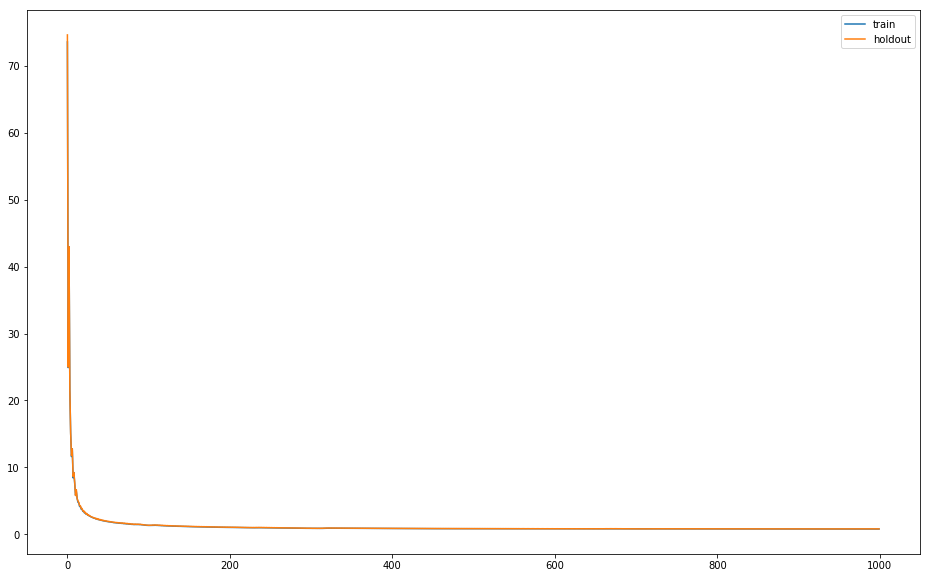

In [7]:
control.plot_losses()

In [8]:
control.clusters['learn_cluster_1'].coefs

tensor([[ 0.1720, -0.2464, -0.5583, -0.3951,  0.1486, -0.6648,  0.2335, -0.1455,
         -0.3564,  0.7645, -0.8466, -0.1485, -0.1603,  0.1468, -1.7301, -0.2611,
          0.2088,  0.5219, -0.8066,  0.0117, -0.8544, -0.4674, -0.7568,  0.0482,
          0.7818, -0.5867, -0.0742, -0.4919, -0.9414, -0.3459,  0.0857, -0.2982,
         -0.1370, -0.5656,  0.1947,  0.3391,  0.0618,  0.1664, -0.9939, -1.1369,
         -0.5743, -0.4449, -0.7598,  0.0063, -0.3799, -0.2055, -0.9991, -0.7567,
          0.3848,  0.2206, -0.8748, -1.8344, -0.0353, -0.3619, -0.3821, -0.5309,
         -0.8247, -0.6298, -0.3084, -0.7849, -0.0449, -0.2235, -0.1333, -0.5972,
         -0.6201,  0.0957, -0.2904,  0.4607, -0.3575,  0.2676,  0.4045, -0.3873,
         -0.0180, -0.6974, -0.2307, -1.1702,  0.4588, -0.1989, -0.6123,  0.4625,
         -0.8670, -0.0066, -0.2502, -0.5883, -0.1854,  1.1111, -0.2885,  0.1010,
         -0.2265,  0.0551, -0.6396, -0.8222, -0.4265, -0.2455, -0.2968, -0.5227,
          0.1113, -0.5826, -